# Image Captioning
### What is Image Captioning ?

* Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
* This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

### CNNs + LSTMs

* To perform Image Captioning we will require two deep learning models combined into one for the training purpose
* CNNs extract the features from the image of some vector size aka the vector embeddings. * The size of these embeddings depend on the type of pretrained network being used for the feature extraction
* LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word.

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## Displaying images with their captions

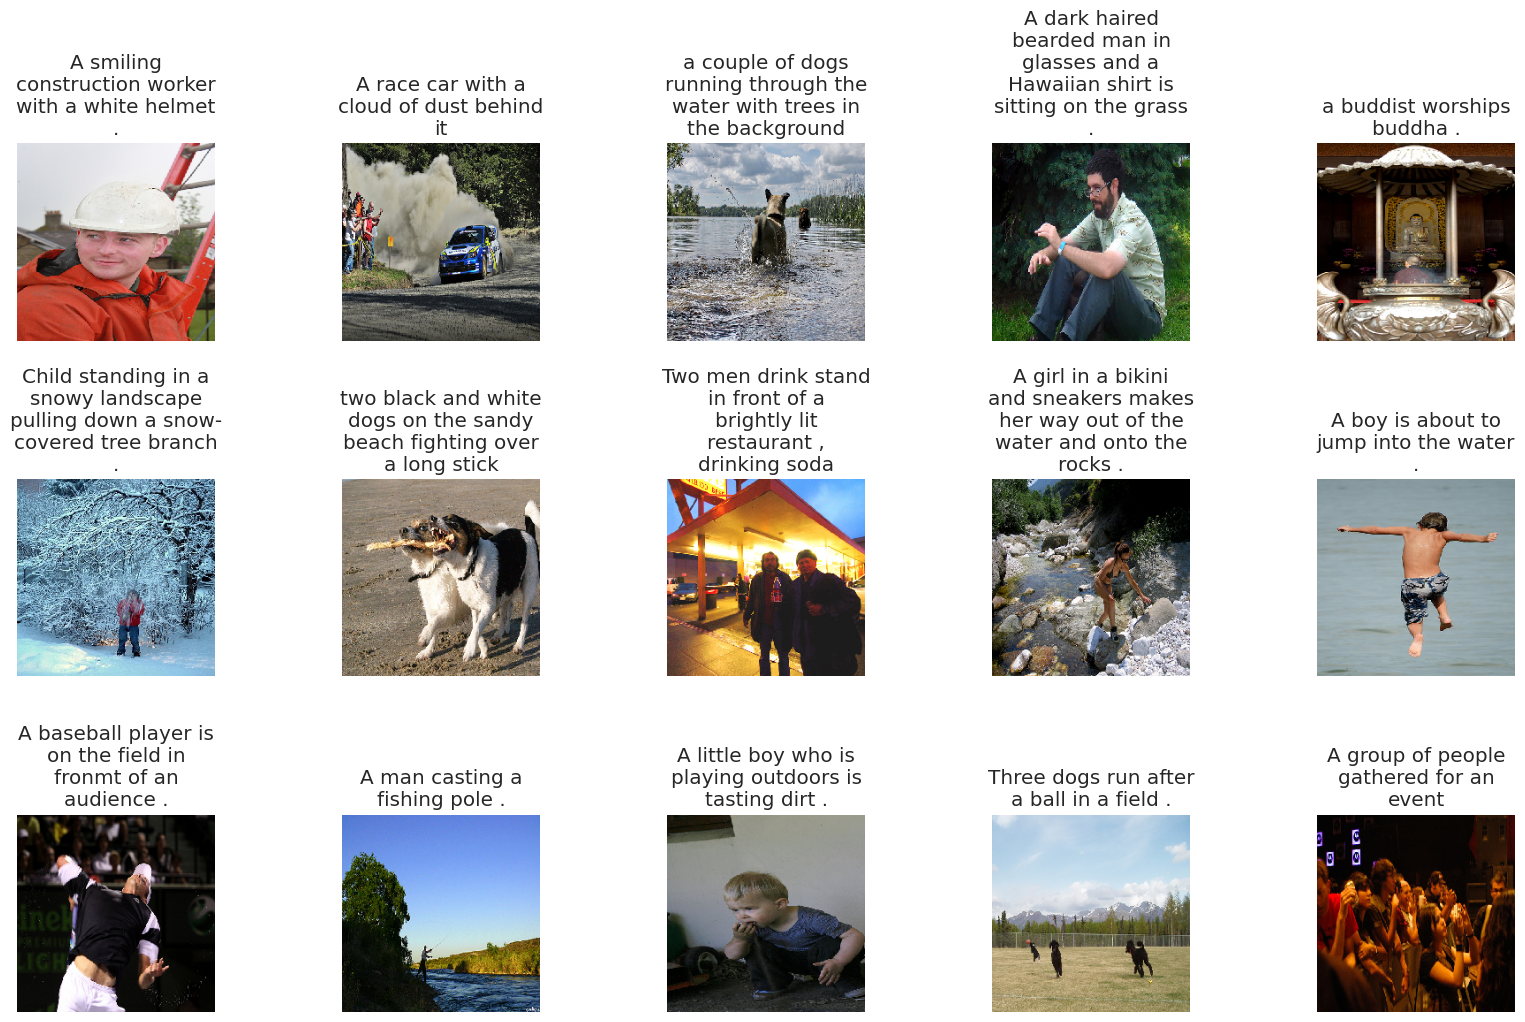

In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

## Caption Text Preprocessing Steps
* Convert sentences into lowercase
* Remove special characters and numbers present in the text
* Remove extra spaces
* Remove single characters
* Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [4]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower()) #lower case every sentence
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]","")) #replacing all special charachters with empty string
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," ")) #removing extra space between 2 words
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) #removing every single letters ex: A
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data 
    
data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Encoded Representation
* The words in a sentence are separated/tokenized and encoded in a one hot representation
* These encodings are then passed to the embeddings layer to generate word embeddings

![](https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif)

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1 #total unique words
max_length = max(len(caption.split()) for caption in captions) #finding max words in sentence
max_length,vocab_size

(34, 8485)

In [6]:
word_index = tokenizer.word_index
first_10_words = {word: idx for word, idx in list(word_index.items())[:10]}
first_10_words

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10}

In [7]:
tokenizer.texts_to_sequences([captions[5]]) #how a sentence looks like

[[1, 14, 8, 7, 842, 8, 16, 342, 2]]

## Creating test and training data

In [8]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

## Image Feature Extraction
* DenseNet 201 Architecture is used to extract the features from the images.
* Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920.

![](https://www.researchgate.net/publication/363776890/figure/fig2/AS:11431281099285164@1669244475702/DenseNet201-architecture.png)

In [10]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output) #removing the last 2 layers

#### What does fe do?
fe is a feature extractor model built from DenseNet201.
##### Here's what it does:
* Takes an image as input (same shape as DenseNet201 expects, e.g., (224, 224, 3)).
* Outputs a feature vector (high-level learned representation) instead of class probabilities.
* It removes the final softmax classification layer, so you get the raw image features — suitable for other tasks like image captioning.
* So instead of predicting labels like "cat", "dog", etc., we want DenseNet to convert the image into a vector of numbers (features), which LSTM can use to generate captions.

In [11]:
#extracting features through fe
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1751669022.984334     101 service.cc:148] XLA service 0x7c72f4003cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751669022.985186     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751669022.985205     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751669025.043641     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751669037.190980     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [14:25<00:00,  9.35it/s]


## Data Generation for Model
* Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
* The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
* The text embeddings are passed word by word for the caption generation during inference time

In [12]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y

    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [13]:
train_generator[0]

((array([[7.8687917e-05, 7.3524052e-04, 1.1395992e-03, ..., 5.6523544e-01,
          2.2903706e-01, 6.9639754e-01],
         [7.8687917e-05, 7.3524052e-04, 1.1395992e-03, ..., 5.6523544e-01,
          2.2903706e-01, 6.9639754e-01],
         [7.8687917e-05, 7.3524052e-04, 1.1395992e-03, ..., 5.6523544e-01,
          2.2903706e-01, 6.9639754e-01],
         ...,
         [1.9476043e-04, 7.0213026e-04, 1.4947485e-03, ..., 2.7233608e-02,
          5.5759734e-01, 3.8916531e-01],
         [1.9476043e-04, 7.0213026e-04, 1.4947485e-03, ..., 2.7233608e-02,
          5.5759734e-01, 3.8916531e-01],
         [1.9476043e-04, 7.0213026e-04, 1.4947485e-03, ..., 2.7233608e-02,
          5.5759734e-01, 3.8916531e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

* first array is the image (X1)
* second array is tokenized captions with padding
* third array is one hot encoding of target(captions) 

## Modelling
* The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
* The LSTM network starts generating words after each input thus forming a sentence at the end

In [14]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,)) #image features from CNN
input2 = Input(shape=(max_length,)) #captions sequences token (e.g., [1, 5, 32, ...])

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features) #reshaping it to match with captions
#(batch_size, 256)->(batch_size, 1, 256)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped,sentence_features],axis=1) #combining caption+images

sentence_features = LSTM(256)(merged)

##### Concatenation (after reshape):
| Image vector    | Caption embedding         | After `concatenate(axis=1)`   |
| --------------- | ------------------------- | ----------------------------- |
| (batch, 1, 256) | (batch, max\_length, 256) | (batch, 1 + max\_length, 256) |

* Now the LSTM can read the whole sequence starting from the image, followed by words — learning to generate a caption based on both.

In [15]:
#for avoiding overfitting
x = Dropout(0.5)(sentence_features) #dropping 50% neurons randomly
x = add([x, img_features]) #add image and text features (element-wise)
#output layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

#Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

#fiiting model
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 5.6981
Epoch 1: val_loss improved from inf to 4.28550, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - loss: 5.6970 - val_loss: 4.2855 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 4.3302
Epoch 2: val_loss improved from 4.28550 to 3.95645, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 139ms/step - loss: 4.3301 - val_loss: 3.9564 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 4.0238
Epoch 3: val_loss improved from 3.95645 to 3.81735, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - loss: 4.0237 - val_loss: 3.8173 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 3.8373
Epoch 4: val_loss improved from 3.81735 to 3.73709, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - loss: 3.8373 - val_loss: 3.7371 - learning_rate: 0.0010


## Learning Curve

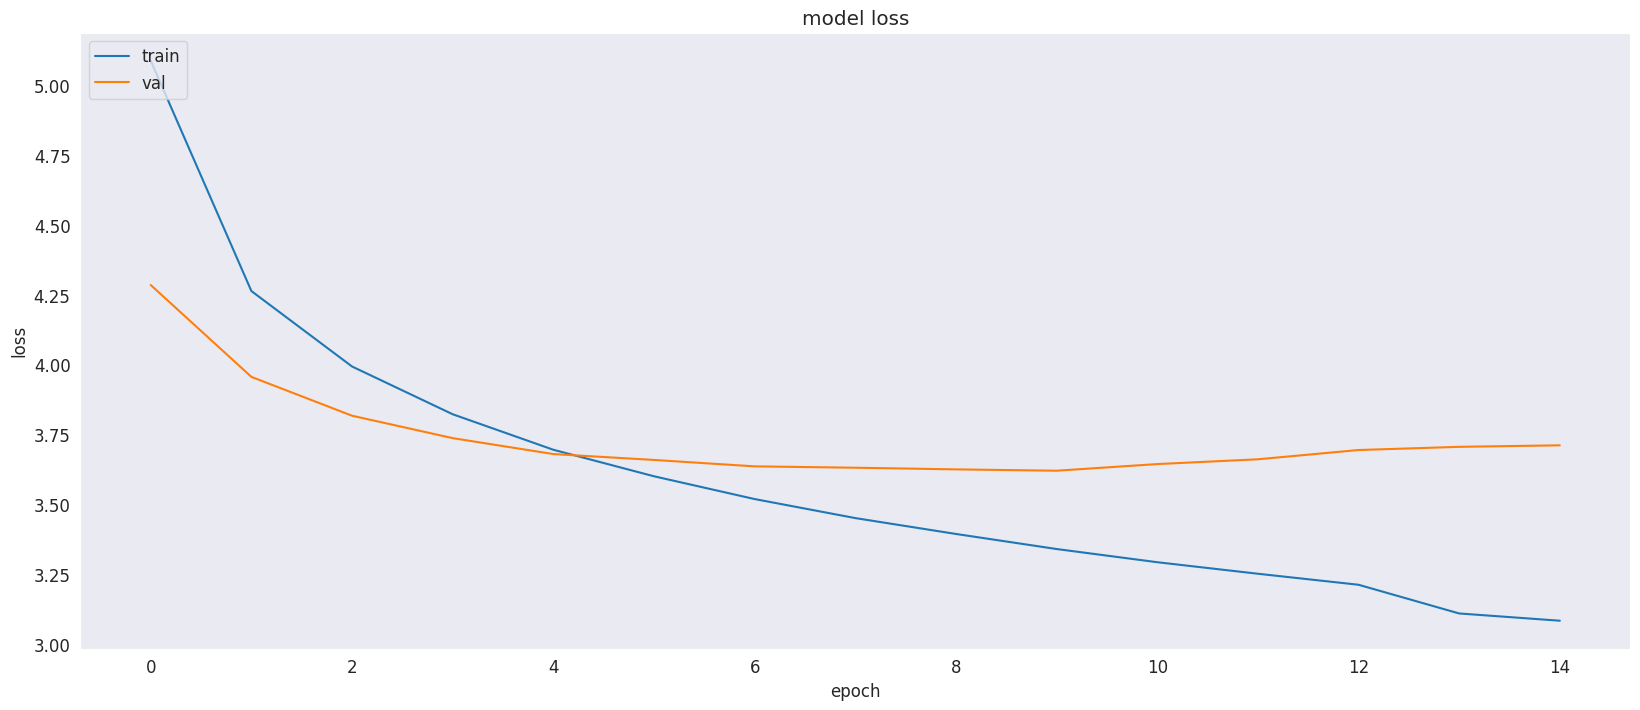

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

* The model has clearly overfit, possibly due to less amount of data
* We can tackle this problem in two ways:
   1. Train the model on a larger dataset Flickr40k
   2. Attention Models

## Caption Generation Utility Functions
* Utility functions to generate the captions of input images at the inference time.
* Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [18]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

### Saving model and making prections

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

In [20]:
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

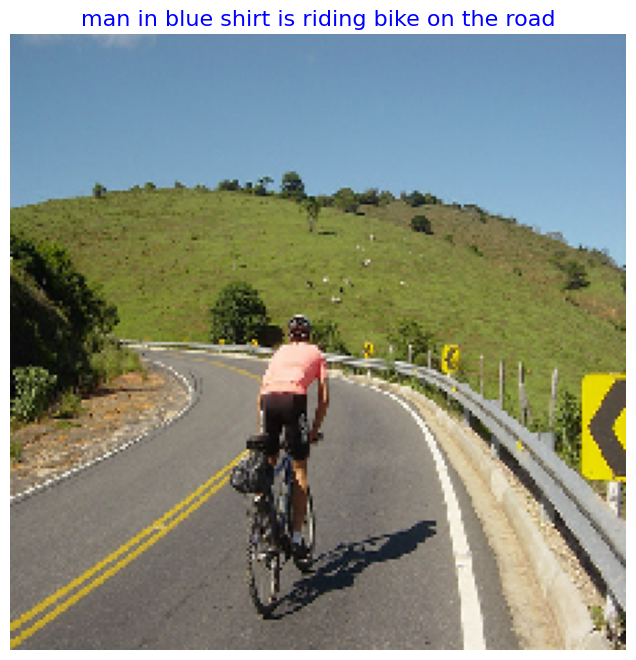

In [21]:
# Example usage
image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

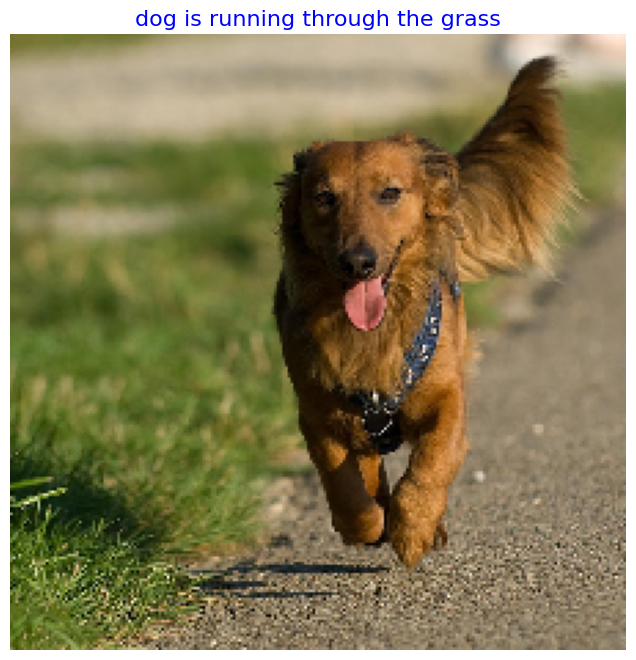

In [22]:
image_path = "/kaggle/input/flickr8k/Images/1089181217_ee1167f7af.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

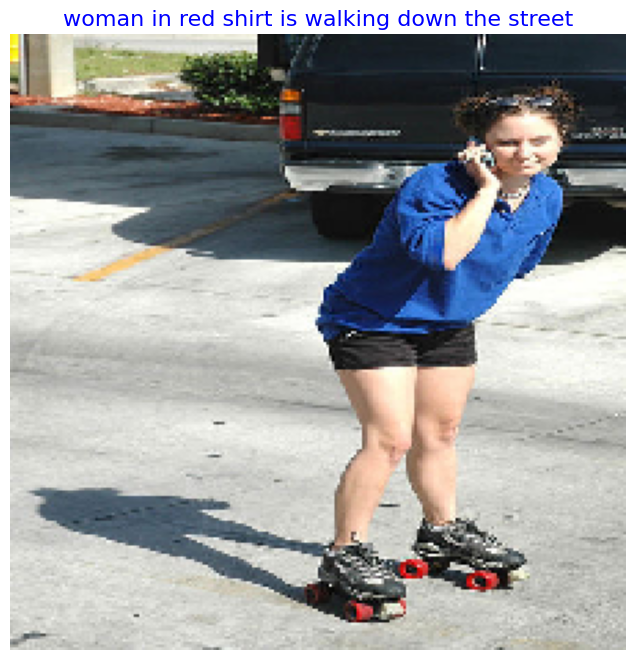

In [23]:
image_path = "/kaggle/input/flickr30k/flickr30k_images/10010052.jpg"  
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)